<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Augmentation을-적용한-데이터셋-만들기" data-toc-modified-id="1.-Augmentation을-적용한-데이터셋-만들기-1">1. Augmentation을 적용한 데이터셋 만들기</a></span><ul class="toc-item"><li><span><a href="#1.1.-데이터-불러오기" data-toc-modified-id="1.1.-데이터-불러오기-1.1">1.1. 데이터 불러오기</a></span></li><li><span><a href="#1.2.-기본-Augmentation" data-toc-modified-id="1.2.-기본-Augmentation-1.2">1.2. 기본 Augmentation</a></span></li><li><span><a href="#1.3.-CutMix" data-toc-modified-id="1.3.-CutMix-1.3">1.3. CutMix</a></span></li><li><span><a href="#1.4.-Mixup" data-toc-modified-id="1.4.-Mixup-1.4">1.4. Mixup</a></span></li><li><span><a href="#1.5.-데이터셋-만들기" data-toc-modified-id="1.5.-데이터셋-만들기-1.5">1.5. 데이터셋 만들기</a></span></li></ul></li><li><span><a href="#2.-모델-만들기" data-toc-modified-id="2.-모델-만들기-2">2. 모델 만들기</a></span></li><li><span><a href="#3.-모델-훈련하기" data-toc-modified-id="3.-모델-훈련하기-3">3. 모델 훈련하기</a></span></li><li><span><a href="#4.-훈련-과정-시각화하기" data-toc-modified-id="4.-훈련-과정-시각화하기-4">4. 훈련 과정 시각화하기</a></span></li><li><span><a href="#5.-Augmentation에-의한-모델-성능-비교" data-toc-modified-id="5.-Augmentation에-의한-모델-성능-비교-5">5. Augmentation에 의한 모델 성능 비교</a></span></li></ul></div>

# 1. Augmentation을 적용한 데이터셋 만들기
## 1.1. 데이터 불러오기

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

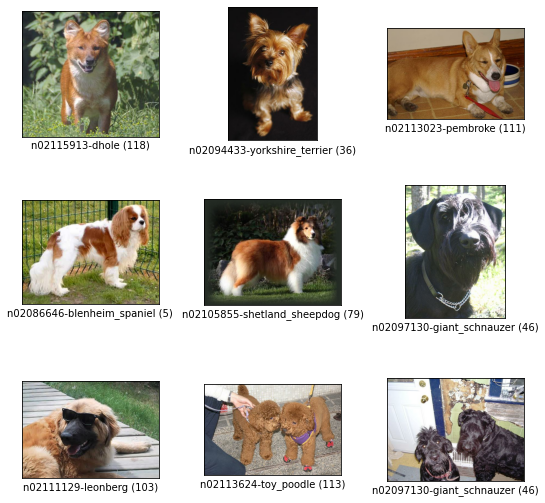

In [4]:
fig = tfds.show_examples(ds_train, ds_info)

## 1.2. 기본 Augmentation
텐서플로우 Random Augmentation 함수 목록
- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [5]:
# 기본적인 전처리 함수
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [6]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [7]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [8]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## 1.3. CutMix
- 이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 방법
- 배치 내의 이미지를 두 개 골라 바운딩 박스의 위치를 랜덤하게 뽑고, 해당 영역을 잘라내서 두 개의 이미지를 섞어준다.
- 섞인 이미지의 전체 이미지 대비 비율을 계산하고, 면적에 비례해서 두 라벨을 섞어준다.

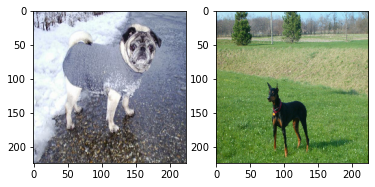

In [9]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

In [10]:
# 바탕 이미지 a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast( tf.random.uniform([],0, image_size_x),tf.int32)
    y = tf.cast( tf.random.uniform([],0, image_size_y),tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    height = tf.cast(image_size_y * tf.math.sqrt(1-tf.random.uniform([],0,1)),tf.int32)
    
    # clip box in image and get minmax bbox
    xa = tf.math.maximum(0, x-width//2)
    ya = tf.math.maximum(0, y-height//2)
    xb = tf.math.minimum(image_size_x, x+width//2)
    yb = tf.math.minimum(image_size_y, y+width//2)
    
    return xa, ya, xb, yb

xa, ya, xb, yb = get_clip_box(image_a, image_b)
print(xa, ya, xb, yb)

tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(75, shape=(), dtype=int32) tf.Tensor(147, shape=(), dtype=int32)


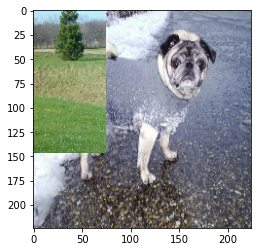

In [11]:
# 바탕이미지 a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
def mix_2_images(image_a, image_b, xa, ya, xb, yb):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    one = image_a[ya:yb,0:xa,:]
    two = image_b[ya:yb,xa:xb,:]
    three = image_a[ya:yb,xb:image_size_x,:]
    middle = tf.concat([one,two,three],axis=1)
    top = image_a[0:ya,:,:]
    bottom = image_a[yb:image_size_y,:,:]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, xa, ya, xb, yb)
plt.imshow(mixed_img.numpy())

In [12]:
# 섞인 이미지의 면적에 비례해서 라벨을 섞어주는 함수
def mix_2_label(label_a, label_b, xa, ya, xb, yb, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (xb-xa)*(yb-ya)
    total_area = image_size_x*image_size_y
    a = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-a)*label_a + a*label_b
    return mixed_label

mixed_label = mix_2_label(label_a, label_b, xa, ya, xb, yb)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [13]:
# 위에서 구현한 두 함수를 활용하여 배치 단위의 cutmix() 함수 구현
def cutmix(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        xa, ya, xb, yb = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, xa, ya, xb, yb))
        mixed_labels.append(mix_2_label(label_a, label_b, xa, ya, xb, yb))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 1.4. Mixup
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식
- 두 이미지를 섞을 비율을 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [14]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.37046564 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

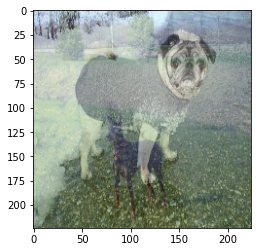

In [18]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

In [19]:
def mixup(image, label, prob = 1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs),(batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels),(batch_size, num_classes))
    return mixed_imgs, mixed_labels

## 1.5. 데이터셋 만들기

In [20]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [21]:
# 배치 단위로 데이터셋을 정렬 후 CutMix와 Mixup을 적용할 수 있도록 수정한 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [22]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# 2. 모델 만들기

In [23]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [24]:
# Augmentation을 적용한 데이터셋으로 학습시킬 ResNet 생성
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [25]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [26]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# 3. 모델 훈련하기
cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었기 때문에 sparse_categorical_crossentropy 대신 categorical_crossentropy를 사용해야 한다.

In [27]:
EPOCH = 20  # Augemtation 적용 효과를 확인하기 위해 필요한 epoch 수

tf.random.set_seed(2021)
resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [28]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 109s 146ms/step - loss: 2.2253 - accuracy: 0.4411 - val_loss: 2.8982 - val_accuracy: 0.2835
Epoch 2/20
750/750 [==============================] - 109s 146ms/step - loss: 0.7918 - accuracy: 0.7769 - val_loss: 1.2060 - val_accuracy: 0.6451
Epoch 3/20
750/750 [==============================] - 110s 146ms/step - loss: 0.3103 - accuracy: 0.9247 - val_loss: 1.0214 - val_accuracy: 0.7083
Epoch 4/20
750/750 [==============================] - 110s 146ms/step - loss: 0.1057 - accuracy: 0.9852 - val_loss: 0.9601 - val_accuracy: 0.7275
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0544 - accuracy: 0.9956 - val_loss: 0.9239 - val_accuracy: 0.7404
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0251 - accuracy: 0.9987 - val_loss: 0.9220 - val_accuracy: 0.7464
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0167 - accuracy: 0.9988 - val_loss: 0.9441 -

In [30]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 110s 146ms/step - loss: 2.2532 - accuracy: 0.4305 - val_loss: 2.7987 - val_accuracy: 0.2950
Epoch 2/20
750/750 [==============================] - 110s 147ms/step - loss: 0.9519 - accuracy: 0.7225 - val_loss: 1.2499 - val_accuracy: 0.6382
Epoch 3/20
750/750 [==============================] - 110s 147ms/step - loss: 0.5198 - accuracy: 0.8572 - val_loss: 1.1504 - val_accuracy: 0.6685
Epoch 4/20
750/750 [==============================] - 110s 147ms/step - loss: 0.2989 - accuracy: 0.9252 - val_loss: 0.9626 - val_accuracy: 0.7226
Epoch 5/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1429 - accuracy: 0.9718 - val_loss: 0.9890 - val_accuracy: 0.7133
Epoch 6/20
750/750 [==============================] - 110s 147ms/step - loss: 0.1148 - accuracy: 0.9795 - val_loss: 0.9821 - val_accuracy: 0.7238
Epoch 7/20
750/750 [==============================] - 110s 147ms/step - loss: 0.0787 - accuracy: 0.9879 - val_loss: 0.9538 -

In [32]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 113s 150ms/step - loss: 3.8372 - accuracy: 0.2085 - val_loss: 3.6627 - val_accuracy: 0.1701
Epoch 2/20
750/750 [==============================] - 113s 150ms/step - loss: 2.9556 - accuracy: 0.4263 - val_loss: 1.4232 - val_accuracy: 0.6063
Epoch 3/20
750/750 [==============================] - 113s 151ms/step - loss: 2.6668 - accuracy: 0.5213 - val_loss: 1.2423 - val_accuracy: 0.6498
Epoch 4/20
750/750 [==============================] - 113s 151ms/step - loss: 2.4453 - accuracy: 0.5925 - val_loss: 1.2060 - val_accuracy: 0.6686
Epoch 5/20
750/750 [==============================] - 113s 151ms/step - loss: 2.2958 - accuracy: 0.6432 - val_loss: 1.2666 - val_accuracy: 0.6576
Epoch 6/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1897 - accuracy: 0.6684 - val_loss: 1.3931 - val_accuracy: 0.6253
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1118 - accuracy: 0.6927 - val_loss: 1.3592 -

In [34]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 114s 152ms/step - loss: 3.7218 - accuracy: 0.2421 - val_loss: 3.6543 - val_accuracy: 0.1665
Epoch 2/20
750/750 [==============================] - 114s 152ms/step - loss: 2.8686 - accuracy: 0.4776 - val_loss: 1.5427 - val_accuracy: 0.5656
Epoch 3/20
750/750 [==============================] - 114s 152ms/step - loss: 2.5662 - accuracy: 0.5804 - val_loss: 1.3524 - val_accuracy: 0.6234
Epoch 4/20
750/750 [==============================] - 114s 152ms/step - loss: 2.4434 - accuracy: 0.6352 - val_loss: 1.2863 - val_accuracy: 0.6446
Epoch 5/20
750/750 [==============================] - 114s 152ms/step - loss: 2.2949 - accuracy: 0.6911 - val_loss: 1.2248 - val_accuracy: 0.6571
Epoch 6/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1924 - accuracy: 0.7301 - val_loss: 1.2289 - val_accuracy: 0.6666
Epoch 7/20
750/750 [==============================] - 113s 151ms/step - loss: 2.1267 - accuracy: 0.7561 - val_loss: 1.2155 -

# 4. 훈련 과정 시각화하기

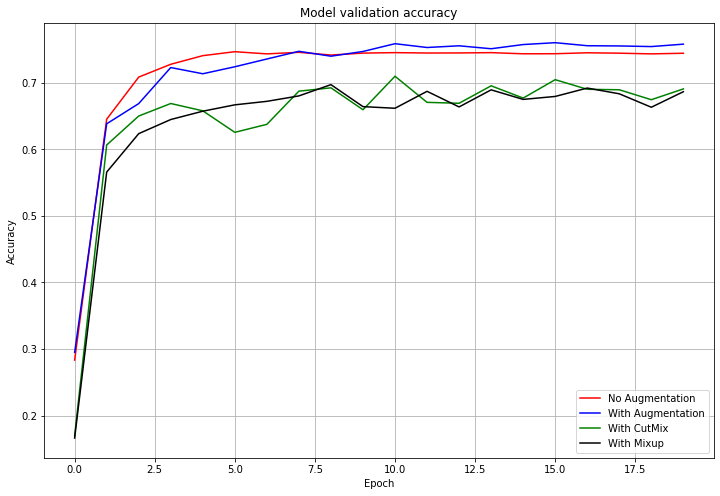

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

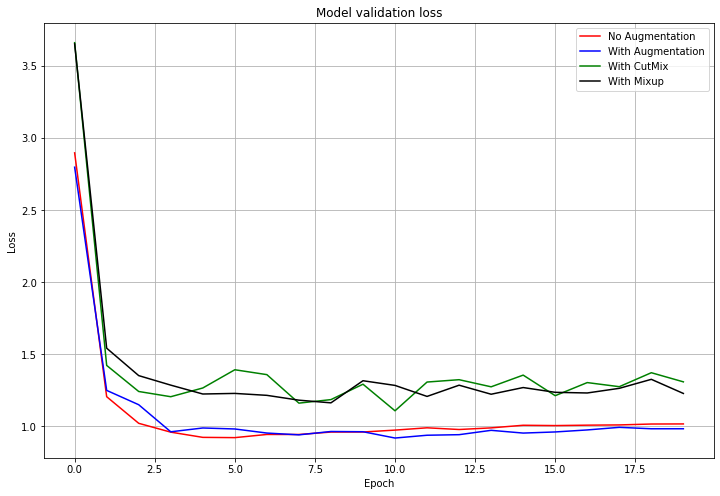

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

# 5. Augmentation에 의한 모델 성능 비교

In [42]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.283465,0.295009,0.170126,0.166511
1,0.645056,0.638176,0.606343,0.565648
2,0.708256,0.668493,0.649837,0.623368
3,0.727495,0.722598,0.668610,0.644590
4,0.740438,0.713270,0.657649,0.657066
5,0.746385,0.723764,0.625350,0.666628
6,0.743120,0.735424,0.637360,0.671875
7,0.745452,0.746968,0.687150,0.680037
8,0.741371,0.739622,0.692164,0.696945
9,0.744286,0.746735,0.659282,0.663946


In [43]:
acc_df.describe()

,No Augmentation,With Augmentation,With CutMix,With Mixup
count,20.000000,20.000000,20.000000,20.000000
mean,0.713345,0.714319,0.646158,0.640800
std,0.103789,0.103673,0.115101,0.115404
min,0.283465,0.295009,0.170126,0.166511
25%,0.741138,0.723472,0.655696,0.660389
50%,0.743703,0.748892,0.672341,0.669251
75%,0.744578,0.755276,0.690094,0.683973
max,0.746385,0.759911,0.709538,0.696945


***
**No Augmentation vs With Augmentation**
- 두 모델의 초기 정확도는 거의 비슷했고, No Augmentation의 성능이 더 빠르게 개선되다가 saturated 되는 양상을 보였다.
- Epoch 8부터는 Augmentation을 적용한 모델의 성능이 더 좋았고, 후반부로 갈수록 그 격차가 점점 더 벌어졌다.

**CutMix vs Mixup**
- 두 모델의 정확도가 엎치락뒤치락하는 양상을 보였으나, 평균과 최댓값을 살펴봤을 때 CutMix의 성능이 약간 더 좋았다.

**기본 Augmentation vs CutMix vs Mixup**
- 기본 Augmentation을 적용한 모델보다 심화 기법인 CutMix와 Mixup을 적용한 모델의 성능이 전반적으로 낮게 나왔다.
- optimizer나 learning rate을 바꿔가며 최적화를 해보면 성능이 오를 수도 있겠지만, 데이터셋 자체에 문제가 있다는 생각이 들었다.

**CutMix와 Mixup의 성능이 낮은 이유에 대한 추측**
- stanford_dogs 데이터셋에는 개가 크게 잘 나온 이미지도 있지만, 배경이 넓고 개는 작게 나온 이미지나 사람이 함께 나온 이미지도 포함되어 있다.
- CutMix는 바운딩 박스의 위치를 랜덤하게 뽑고 해당 영역을 잘라내서 두 이미지를 합성한다. 이때 아래 예시처럼 한쪽 이미지에서 개와 무관한 배경만 잘리거나 사람만 잘린 경우가 있어 모델의 성능이 저하되었을 가능성이 있다.

안 좋은 예 1 | 안 좋은 예 2
:--:|:--:
배경만 잘린 경우 | 사람만 잘린 경우
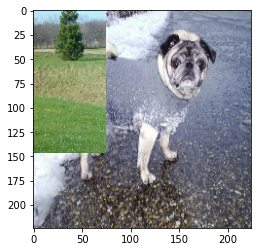|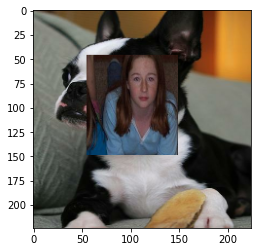
